Memulai proses pemuatan dan pembersihan data...
Pembersihan dan rekayasa fitur selesai.

Contoh 5 baris data yang telah diproses:
       sex  age       age_cat              race  juv_fel_count  juv_misd_count  juv_other_count  priors_count c_charge_degree  length_of_stay  two_year_recid
1     Male   34       25 - 45  African-American              0               0                0             0               F              10               1
2     Male   24  Less than 25  African-American              0               0                1             4               F               1               1
6     Male   41       25 - 45         Caucasian              0               0                0            14               F               6               1
8   Female   39       25 - 45         Caucasian              0               0                0             0               M               2               0
10    Male   27       25 - 45         Caucasian              0               0  

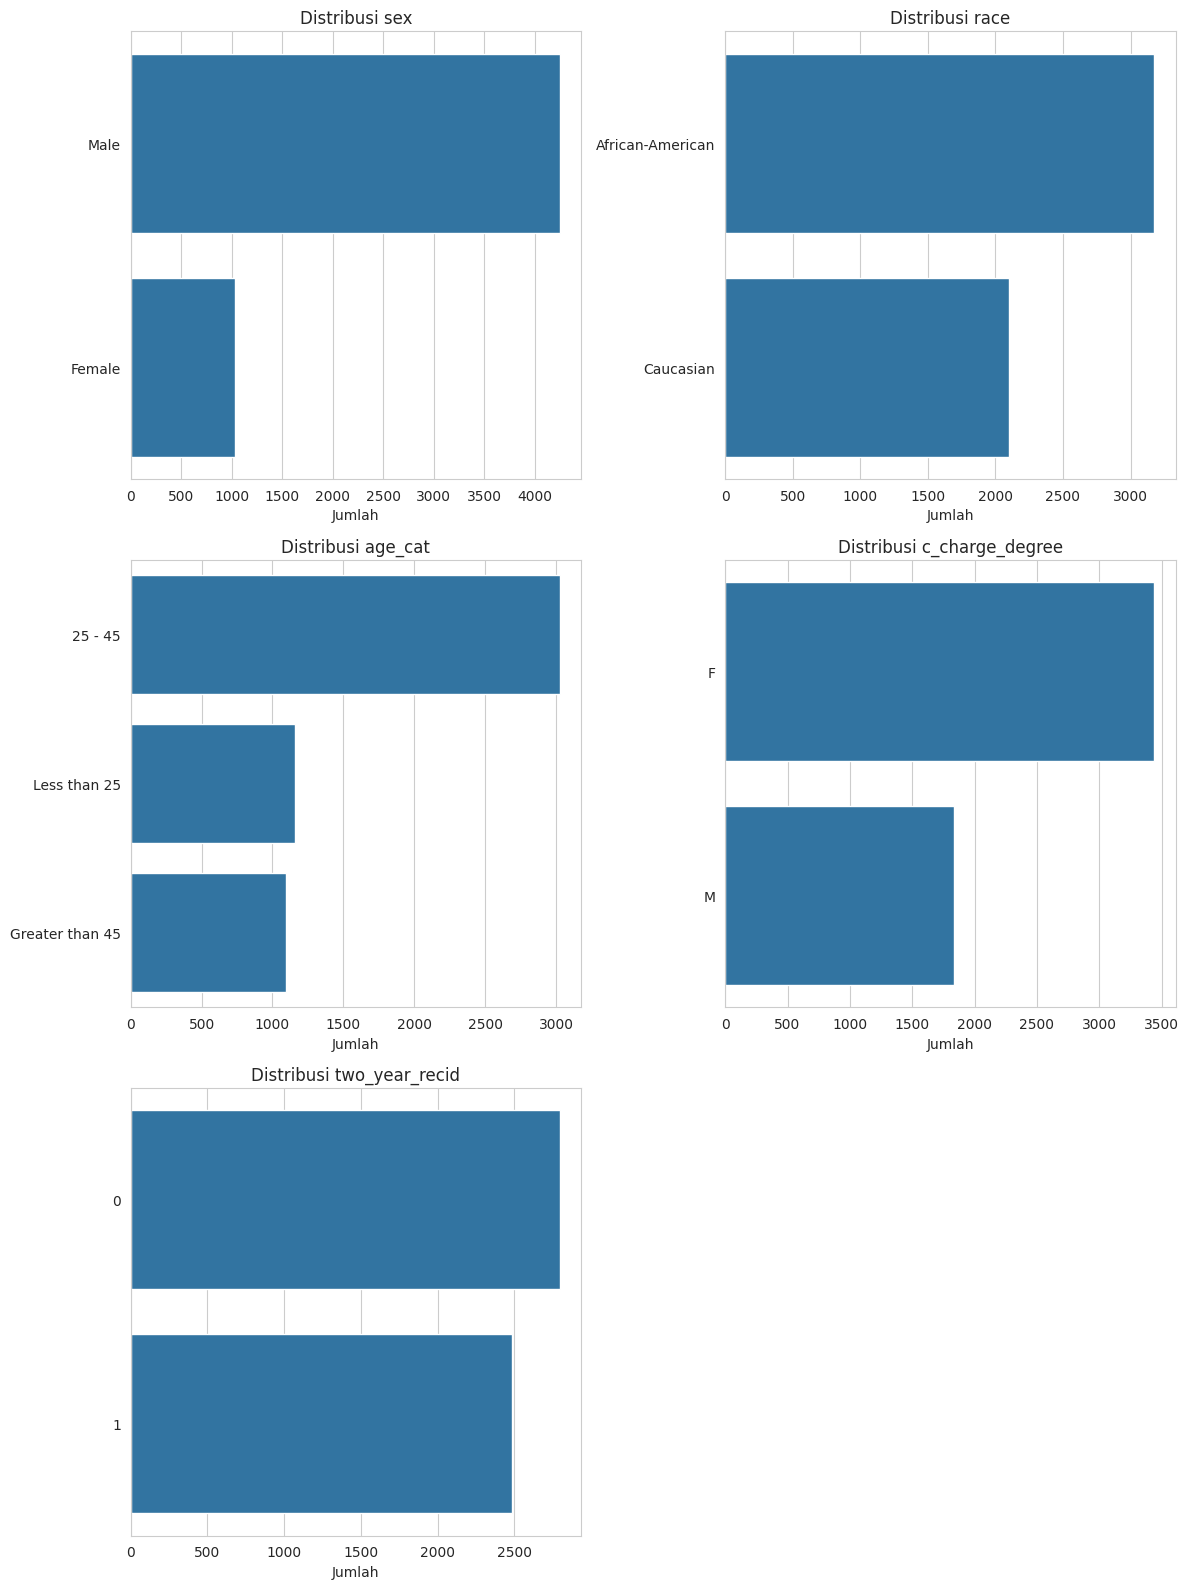


2. Distribusi Fitur Numerik:


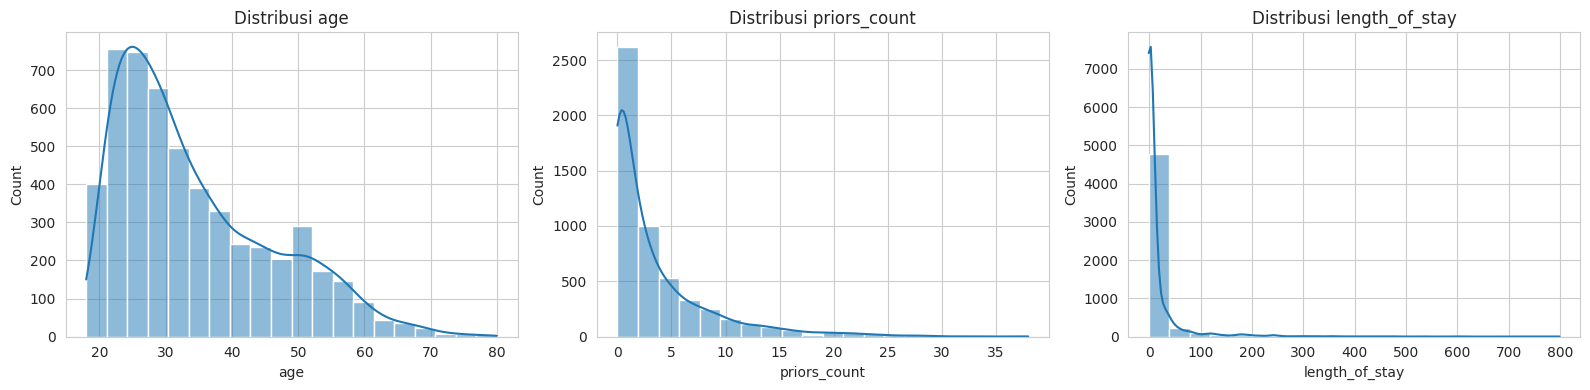


3. Hubungan Fitur Kategori dengan Residivisme:


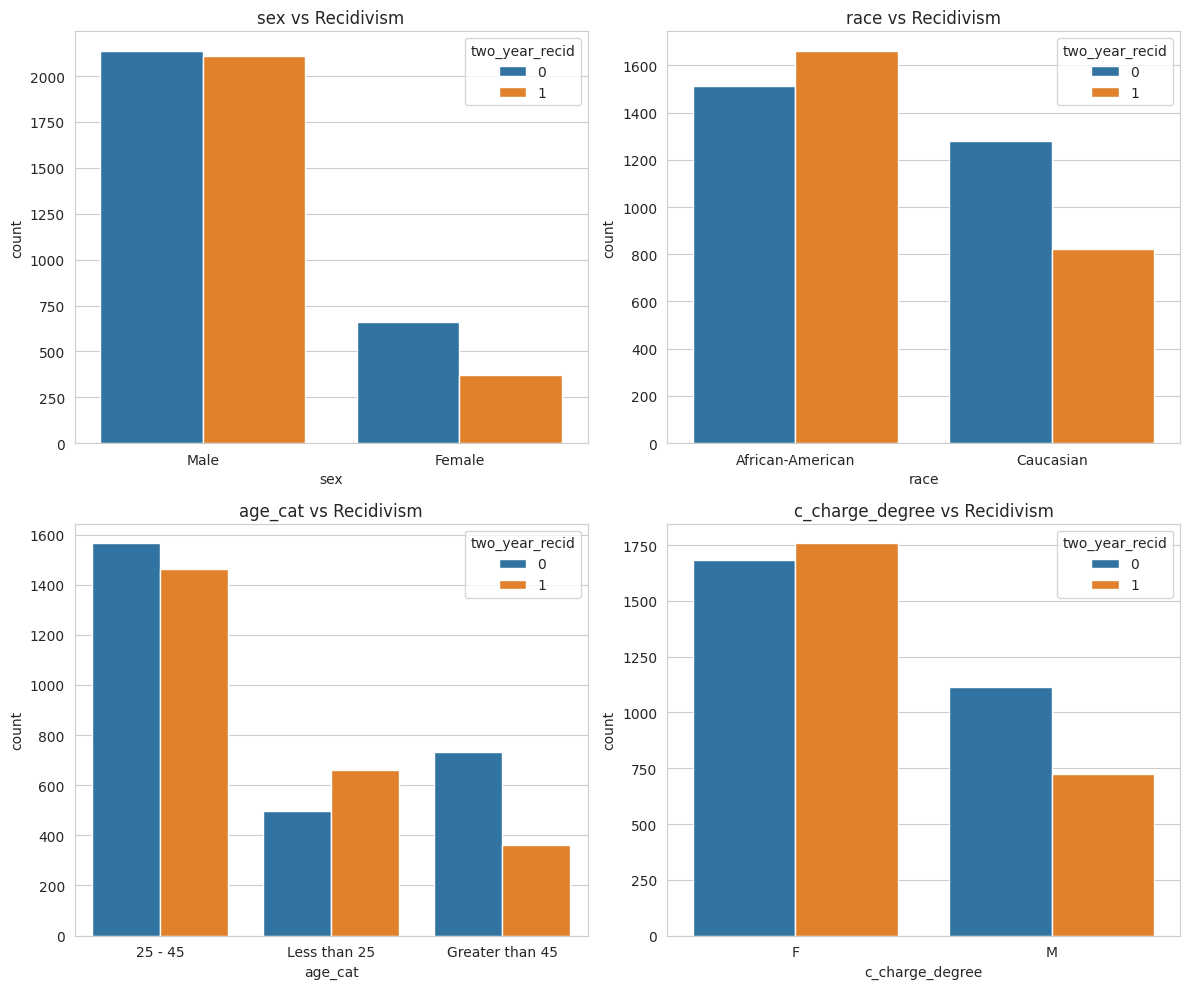


--- Mempersiapkan Data dan Melatih Model ---
Pelatihan model selesai.

--- Hasil Evaluasi Model Klasifikasi ---
Akurasi   : 0.6667
Presisi   : 0.6656
Recall    : 0.5852
F1-Score  : 0.6229
AUC       : 0.7200

4. Kurva ROC (Receiver Operating Characteristic):


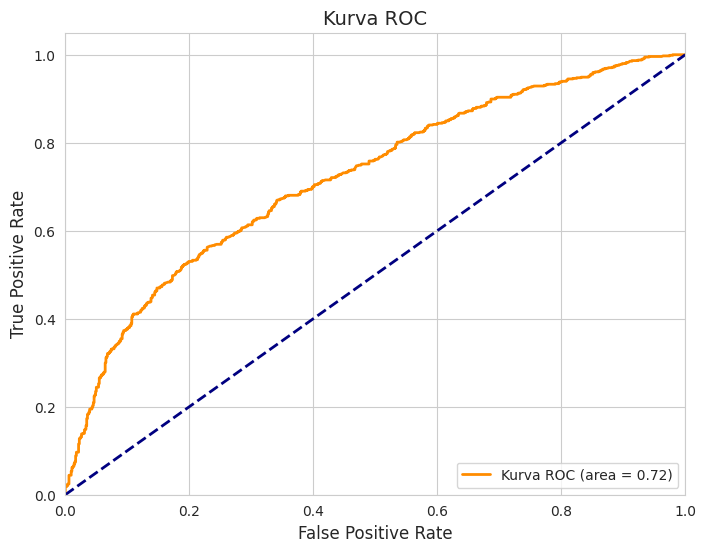

In [2]:
# 1. Impor Pustaka yang Diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# --- TAHAP 1: PEMUATAN, PEMBERSIHAN, DAN REKAYASA FITUR ---
print("Memulai proses pemuatan dan pembersihan data...")
# Memuat dataset dari file
try:
    df = pd.read_csv('compas-scores-two-years.csv')
except FileNotFoundError:
    print("Pastikan file 'compas-scores-two-years.csv' berada di direktori yang sama.")
    exit()

# Melakukan pemfilteran data
df_filtered = df[
    (df['days_b_screening_arrest'] <= 30) &
    (df['days_b_screening_arrest'] >= -30) &
    (df['is_recid'] != -1) &
    (df['c_charge_degree'] != 'O') &
    (df['score_text'].notna()) &
    (df['race'].isin(['African-American', 'Caucasian']))
].copy()

# Rekayasa Fitur: Membuat fitur 'length_of_stay'
df_filtered['c_jail_in'] = pd.to_datetime(df_filtered['c_jail_in'])
df_filtered['c_jail_out'] = pd.to_datetime(df_filtered['c_jail_out'])
df_filtered['length_of_stay'] = (df_filtered['c_jail_out'] - df_filtered['c_jail_in']).dt.days

# Memilih fitur-fitur yang akan digunakan
features_to_use = [
    'sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count',
    'juv_other_count', 'priors_count', 'c_charge_degree', 'length_of_stay', 'two_year_recid'
]
df_final = df_filtered[features_to_use].copy()

# Menangani baris dengan data yang hilang
df_final.dropna(inplace=True)
print("Pembersihan dan rekayasa fitur selesai.")
print("\nContoh 5 baris data yang telah diproses:")
print(df_final.head().to_string())


# --- TAHAP 2: VISUALISASI DATA (EDA) ---
print("\n--- Menampilkan Visualisasi Data ---")
sns.set_style("whitegrid")

# Visualisasi Distribusi Fitur Kategori
print("\n1. Distribusi Fitur Kategori:")
fig, axes = plt.subplots(3, 2, figsize=(12, 16))
axes = axes.flatten()
cat_features_viz = ['sex', 'race', 'age_cat', 'c_charge_degree', 'two_year_recid']
for i, col in enumerate(cat_features_viz):
    sns.countplot(y=col, data=df_final, ax=axes[i], order=df_final[col].value_counts().index)
    axes[i].set_title(f'Distribusi {col}', fontsize=12)
    axes[i].set_xlabel('Jumlah')
    axes[i].set_ylabel('')
# Sembunyikan subplot terakhir yang tidak terpakai
axes[-1].set_visible(False)
fig.tight_layout()
plt.show()

# Visualisasi Fitur Numerik
print("\n2. Distribusi Fitur Numerik:")
num_features_viz = ['age', 'priors_count', 'length_of_stay']
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for i, col in enumerate(num_features_viz):
    sns.histplot(df_final[col], bins=20, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribusi {col}', fontsize=12)
fig.tight_layout()
plt.show()

# Visualisasi Hubungan Fitur dengan Target (two_year_recid)
print("\n3. Hubungan Fitur Kategori dengan Residivisme:")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
cat_features_vs_target = ['sex', 'race', 'age_cat', 'c_charge_degree']
for i, col in enumerate(cat_features_vs_target):
    sns.countplot(x=col, data=df_final, hue='two_year_recid', ax=axes[i])
    axes[i].set_title(f'{col} vs Recidivism', fontsize=12)
fig.tight_layout()
plt.show()


# --- TAHAP 3: PERSIAPAN DATA DAN PEMODELAN ---
print("\n--- Mempersiapkan Data dan Melatih Model ---")
# Mengubah fitur kategori menjadi dummy variables
df_model = pd.get_dummies(df_final, drop_first=True)
X = df_model.drop('two_year_recid', axis=1)
y = df_model['two_year_recid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Melatih Model Regresi Logistik
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
print("Pelatihan model selesai.")


# --- TAHAP 4: EVALUASI MODEL ---
print("\n--- Hasil Evaluasi Model Klasifikasi ---")
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Menampilkan hasil evaluasi
print(f"Akurasi   : {accuracy_score(y_test, y_pred):.4f}")
print(f"Presisi   : {precision_score(y_test, y_pred):.4f}")
print(f"Recall    : {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score  : {f1_score(y_test, y_pred):.4f}")
print(f"AUC       : {roc_auc_score(y_test, y_pred_proba):.4f}")

# Menampilkan Kurva ROC
print("\n4. Kurva ROC (Receiver Operating Characteristic):")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Kurva ROC (area = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Kurva ROC', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()